In [25]:
#Amanda Sinning, created January 2024, last edited April 2024
#Purpose of this code briefly described below
'''
-Orographically enhanced rainfall: rainfall that is enhanced by terrain features, which provide extra vertical lift
-more vertical lift leads to more condensation, and often heavier precipitation

For the case of Hurricane Ivan (2004):
-Analyze how orographic versus non-orographic rainfall may change in a future climate, quantitatively using storm total water mass
-If orographically-enhanced rainfall rainfall exhibits different changes in our future climate simulations, could have implications for mitigation & resilience

-We will representative define area(s) of orographically-enhanced and less orographically-enhanced (or non-orographically enhanced) 
-These areas will be the same size, and around the same latitude, for the best comparison
'''
pass #included so that the block comment doesn't print itself

In [26]:
#load needed packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, TwoSlopeNorm
from matplotlib.animation import FuncAnimation, PillowWriter
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
from shapely.geometry import Polygon, Point
import scipy.ndimage as ndimage
import wrf
from wrf import (to_np, getvar, smooth2d, get_cartopy, latlon_coords)

In [27]:
#Load dataset for Hurricane Ivan using xarray from the specified path
file= xr.open_dataset("/scratch/amanda/ivan_present_ensembles/ens1_ivan/wrfout_d02_2004-09-17_12:00:00")

#XLAT and XLONG are latitude and longitude values & 'LANDMASK' indicates land-water boundaries
lat = file.variables['XLAT'][0,:,:]
lon = file.variables['XLONG'][0,:,:]

landmask = file.variables['LANDMASK'][0,:,:] #get landmask for plotting

print(np.shape(lon))
#the above file needed to be loaded since it has the same geographical data as the files used to create the PMM rainfall arrays (loaded below)
#the saved PMM (probability matched mean) rainfall arrays do not have associated metadata

(738, 405)


In [28]:
#load ensemble PMM (probability matched mean) arrays for present and future scenarios (analyze changes in precipitation)

#only need to load the last PMM file to calculate storm total water mass
ens_pmm_precip_PRES = np.load('/scratch/amanda/ivan_present_ensembles/pmm_ensmean_presentd02_18_23.npy')

ens_pmm_precip_FUT = np.load('/scratch/amanda/pgw_ivan_ensembles/pmm_ensmean_futured02_18_23.npy')

print('loaded arrays')

loaded arrays


In [29]:
#FLAGS TO SET
storm = 'Ivan' #will implement these flags soon, once the simulations of other storms have completed
vers = 'pgw'

oro_rain = True #if want to preform calculations for the orographic area, set to true (otherwise, set to false)
new_array_oro = False #if a new array for the orographic region needs calculated set to true (otherwise, set to false, and existing arrays are loaded)

non_oro_rain = False #if want to preform calculations for the NON-orographic area, set to true (otherwise, set to false)
new_array_NONoro = False #same usage as new_array_oro flag above, just for non-oro

west_nonoro_box = False #if want to scoot the box west to capture nonoro rain, set to true, if want to scoot east, set to false

[(-83.80000000000001, 34.4), (-84.4, 35.4), (-81.0, 37.1), (-80.4, 36.1)]


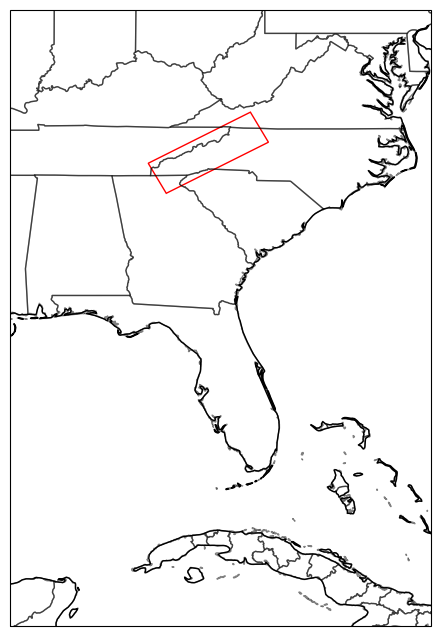

In [30]:
'''''
define box for orographic rain, having an irregular polygon as a box require extra steps
'''''
# Define the endpoints of the Appalachian mtn section
southwest = (-83.9,34.9)  
northeast = (-80.9,36.6) #WRF is lon,lat, so need to flip the coordinates for them to be found in the data!

# Calculate the buffer distance for latitude and longitude
lat_buffer = 0.5
lon_buffer1 = 0.5  
lon_buffer2 = 0.1

vertices = [
    (southwest[0] + lon_buffer2, southwest[1] - lat_buffer),
    (southwest[0] - lon_buffer1, southwest[1] + lat_buffer),
    (northeast[0] - lon_buffer2, northeast[1] + lat_buffer),
    (northeast[0] + lon_buffer1, northeast[1] - lat_buffer),
]

print(vertices)

# quickly plot polygon to check verticies ########
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})

ax.set_extent([-89, -75, 20, 40.5],ccrs.PlateCarree()) #set map extent

# Add coastlines, states, and country borders for context
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.STATES, linestyle='-', alpha=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add polygon to map
polygon = plt.Polygon(vertices, closed=True, edgecolor='red', fill=False)
ax.add_patch(polygon)

plt.show()

In [31]:
'''''
Use np.where to see if a point is included inside the box area. For an irregular polygon, need to create a masked array
This array represents if a point is in or out of polygon, then use the mask array to filter the precip data to only include points inside polygon
'''''

if oro_rain and new_array_oro: #if we want to analyze the orographic rain area, and need a new array calculated

    polygon = Polygon(vertices) #create a polygon object from verticies (calculated above)

    # Initialize an empty mask array with the same shape as precip data
    #this will be used to store the mask array that says if a point is in or out of polygon
    mask = np.zeros_like(ens_pmm_precip_PRES, dtype=bool)

    #fill the mask (looping thru every point in array)
    for i in range(lat.shape[0]):
        for j in range(lat.shape[1]):
            point = Point(lon[i, j], lat[i, j]) #loop through every single point in array (which we specified by saying for all the points in the 2 dimensions of lat array)
            mask[i, j] = polygon.contains(point)

    # Now use this mask with np.where to filter data, mask the precip outside the polygon as NAN
    prec_pres = np.where(mask, ens_pmm_precip_PRES, np.nan)
    prec_pgw = np.where(mask, ens_pmm_precip_FUT, np.nan)

    print(np.shape(prec_pgw))
    print(np.shape(prec_pres))
    
    #these are the newly calculated masked arrays that will be used later to calculate storm total water mass
    np.save('/scratch/amanda/ivan_present_ensembles/app._mtns_box_masked_pmmPRECIP_PRES.npy', prec_pres)
    np.save('/scratch/amanda/pgw_ivan_ensembles/app._mtns_box_masked_pmmPRECIP_FUT.npy', prec_pgw)

elif oro_rain: #if a new array does not need calculated, just load existing array
    
    prec_pres = np.load('/scratch/amanda/ivan_present_ensembles/app._mtns_box_masked_pmmPRECIP_PRES.npy')
    prec_pgw = np.load('/scratch/amanda/pgw_ivan_ensembles/app._mtns_box_masked_pmmPRECIP_FUT.npy')
    print('arrays masked for ens. PMM over mtns loaded')


arrays masked for ens. PMM over mtns loaded


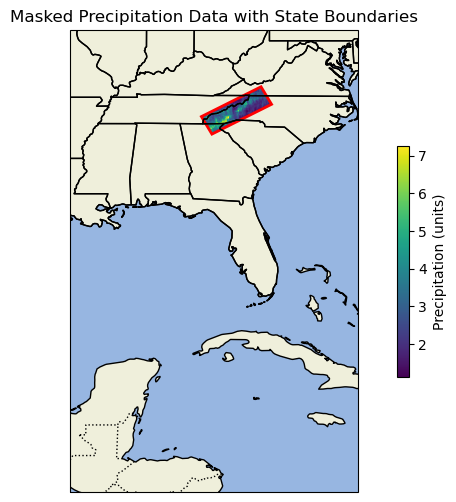

In [32]:
#make quick a plot to double check that the mask worked properly

if oro_rain:

    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    # Add states, geographic features, etc. for reference
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle='-', edgecolor='black')

    precipitation_plot = ax.pcolormesh(lon, lat, prec_pgw, shading='auto', transform=ccrs.PlateCarree()) # Plot masked data

    # Add the polygon to the plot
    polygon = plt.Polygon(vertices, edgecolor='red', facecolor='none', lw=2, transform=ccrs.PlateCarree())
    ax.add_patch(polygon)

    # Set plot limits to the bounds of the data, just to be sure everything is masked
    ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())

    cbar = plt.colorbar(precipitation_plot, ax=ax, shrink=0.5) # Add colorbar for reference
    cbar.set_label('Precipitation (units)')

    # Add labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Masked Precipitation Data with State Boundaries')

    plt.show()

In [36]:
'''''
define box for NON-OROGRAPHIC (or less-orographic) rain, we want it to be the same shape and size as orographic box for the best comparison
This box is simply moved right or left to maintain similar latitude to the orographic box (again, for better comparison)
'''''
if non_oro_rain:
    ##WRF is lon,lat, so need to flip the coordinates for them to be found in the data!
    if west_nonoro_box:
        southwest = (-86.9,34.9) ##coords to scoot it WEST
        northeast = (-84.9,36.6) ##coords to scoot it WEST
    else:
        southwest = (-80.9,34.9) ##coords to scoot it EAST
        northeast = (-78.9,36.6) ##coords to scoot it EAST

    # Calculate the buffer distance for latitude and longitude
    lat_buffer = 0.5
    lon_buffer1 = 0.5  
    lon_buffer2 = 0.1

    vertices_nonoro = [
        (southwest[0] + lon_buffer2, southwest[1] - lat_buffer),
        (southwest[0] - lon_buffer1, southwest[1] + lat_buffer),
        (northeast[0] - lon_buffer2, northeast[1] + lat_buffer),
        (northeast[0] + lon_buffer1, northeast[1] - lat_buffer),
    ]

    print(vertices_nonoro)

    ## plot the polygon to check accuracy####
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})

    ax.set_extent([-89, -75, 20, 40.5],ccrs.PlateCarree()) #set map extent

    # Add coastlines, states, and country borders for context
    ax.coastlines(resolution='50m')
    ax.add_feature(cfeature.STATES, linestyle='-', alpha=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Add the polygon to the map
    polygon = plt.Polygon(vertices_nonoro, closed=True, edgecolor='red', fill=False)
    ax.add_patch(polygon)

    plt.show()

In [38]:
'''''
MASK the precip data for NON oro rain box area(s)
test to see if a point is included in the polygon above, to mask the data to only include points inside polygon
'''''
if non_oro_rain and new_array_NONoro:

    polygon1 = Polygon(vertices_nonoro) #create a polygon object from verticies (calculated above)

    #this will be used to store the mask array that defines if a point is in or out of polygon
    mask = np.zeros_like(ens_pmm_precip_PRES, dtype=bool)

    #fill the mask
    for i in range(lat.shape[0]):
        for j in range(lat.shape[1]):
            point = Point(lon[i, j], lat[i, j]) #loop through every single point in array (which we specified by saying for all the points in the 2 dimensions of lat array)
            mask[i, j] = polygon1.contains(point)

    # Now use this mask with np.where to filter data, mask the precip outside the polygon as NAN
    prec_pgw = np.where(mask, ens_pmm_precip_PRES, np.nan)
    prec_pres = np.where(mask, ens_pmm_precip_FUT, np.nan)
    
    if west_nonoro_box: #these are the newly calculated masked arrays that will be used later to calculate storm total water mass
        np.save('/scratch/amanda/ivan_present_ensembles/nonoro_area_masked_pmmPRECIP_PRES_westscoot.npy', prec_pres)
        np.save('/scratch/amanda/pgw_ivan_ensembles/nonoro_area_masked_pmmPRECIP_FUT_westscoot.npy', prec_pgw)
    else:
        np.save('/scratch/amanda/ivan_present_ensembles/nonoro_area_masked_pmmPRECIP_PRES_eastscoot.npy', prec_pres)
        np.save('/scratch/amanda/pgw_ivan_ensembles/nonoro_area_masked_pmmPRECIP_FUT_eastscoot.npy', prec_pgw)

elif non_oro_rain: #if a new array does not need calculated, just load existing array
    
    if west_nonoro_box: 
        prec_pres = np.load('/scratch/amanda/ivan_present_ensembles/nonoro_area_masked_pmmPRECIP_PRES_westscoot.npy')
        prec_pgw = np.load('/scratch/amanda/pgw_ivan_ensembles/nonoro_area_masked_pmmPRECIP_FUT_westscoot.npy')
    else:
        prec_pres = np.load('/scratch/amanda/ivan_present_ensembles/nonoro_area_masked_pmmPRECIP_PRES_eastscoot.npy')
        prec_pgw = np.load('/scratch/amanda/pgw_ivan_ensembles/nonoro_area_masked_pmmPRECIP_FUT_eastscoot.npy')
        
    print('arrays masked for ens. PMM nonoro area loaded')

In [40]:
'''''
now calculate total water mass, it is calculated for either orographic or non-oro rain depends on the flag oro_rain at script start
Possibly make this and above cells into a function at some point to shorten script
'''''
#add a landmask just in case, since one of my boxes clips the ocean
landonly_prec_pgw = np.where(landmask, prec_pgw, np.nan) #where the landmask is true, orig. data is kept, where the landmask is false (ocean, data is set to np.nan)
landonly_prec_pres = np.where(landmask, prec_pres, np.nan)

## convert from inches to meters (these values will be what we use in the final total water mass calculation)
landonly_prec_pres = landonly_prec_pres * 0.0254
landonly_prec_pgw = landonly_prec_pgw * 0.0254

#get total volume of precip by multiplying the precip depth (m) by the area each point represents(grid spacing in m)
area = 4000 * 4000 #DEPENDENT ON GRID SPACING!!! adjust accordingly
landonly_prec_pres_v = landonly_prec_pres * area
landonly_prec_pgw_v = landonly_prec_pgw * area #multiply each point by the area it encompasses in m^2 to get volume
print('total volume of water pres: ', np.nansum(landonly_prec_pres_v), ' m^3')
print('total volume of water pgw: ', np.nansum(landonly_prec_pgw_v), ' m^3')

#now to get mass in trillions of kg, multiply volume by density of water (converting volume of water to mass of water)
dens = 1000 #kg/m^3
landonly_prec_pres_m = landonly_prec_pres_v * dens/ 10E12
landonly_prec_pgw_m = landonly_prec_pgw_v * dens/ 10E12
print('total mass of water pres: ', np.nansum(landonly_prec_pres_m), ' tril. kg')
print('total mass of water pgw: ', np.nansum(landonly_prec_pgw_m), ' tril. kg')

## convert from kg to gallons and in gallons
gal = 0.264172052358
landonly_prec_pres_g = landonly_prec_pres_m * gal 
landonly_prec_pgw_g = landonly_prec_pgw_m * gal 
print('total mass of water pres: ', np.nansum(landonly_prec_pres_g), ' tril. gal')
print('total mass of water pgw: ', np.nansum(landonly_prec_pgw_g), ' tril. gal')

#calculate percent difference for both the gallons and final total water mass, to make sure calculation is correct
#these percent differences should be the same!
print('perdiff_g: ', (np.nansum(landonly_prec_pgw_g) - np.nansum(landonly_prec_pres_g))/np.nansum(landonly_prec_pres_g)*100)
print('perdiff_mass: ', (np.nansum(landonly_prec_pgw_m) - np.nansum(landonly_prec_pres_m))/np.nansum(landonly_prec_pres_m)*100)

total volume of water pres:  3733964799.016714  m^3
total volume of water pgw:  3905388277.441263  m^3
total mass of water pres:  0.37339647990167135  tril. kg
total mass of water pgw:  0.3905388277441263  tril. kg
total mass of water pres:  0.09864091443887725  tril. gal
total mass of water pgw:  0.10316944365065328  tril. gal
perdiff_g:  4.590923794184947
perdiff_mass:  4.590923794184973


(738, 405)


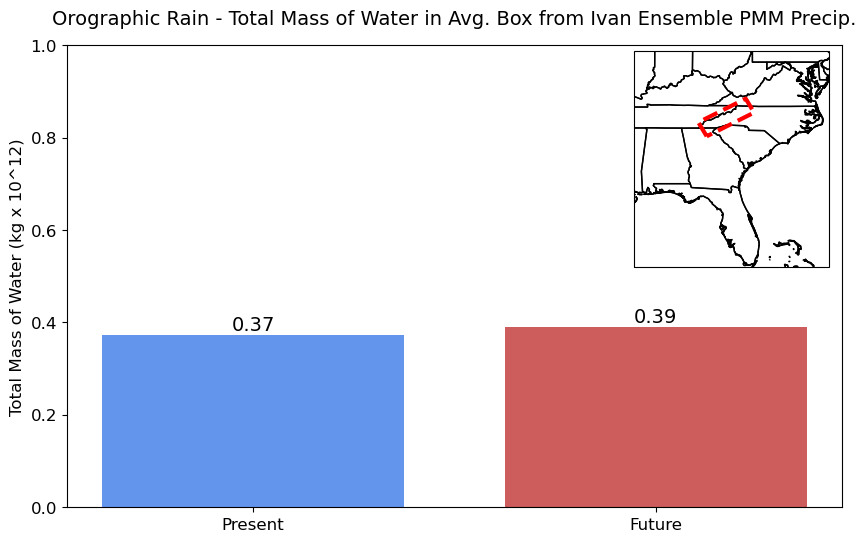

In [21]:
'''''''''''''''
create bar plot with an inset of the geographical area of interest (avg box)
'''''''''''''''
def addlabels(x, y, z):
    for i in range(len(x)):
        plt.text(i, y[i], z[i], ha='center', va='bottom', fontsize=14)

lmeans = ['{:.2f}'.format(float(np.nansum(landonly_prec_pres_m))), 
          '{:.2f}'.format(float(np.nansum(landonly_prec_pgw_m)))]
means = [float(np.nansum(landonly_prec_pres_m)), float(np.nansum(landonly_prec_pgw_m))]
colors = ['cornflowerblue', 'indianred']
xaxis = ['Present', 'Future']
x_axis = np.arange(len(xaxis))

print(np.shape(landonly_prec_pgw_m))

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x_axis, means, color=colors, width=0.75, label='Present Simulation') #create bar plot
addlabels(x_axis, means, lmeans) #add labels for total water mass value above each bar

# Plot settings
ax.set_xticks(x_axis)
ax.set_xticklabels(xaxis)
ax.set_ylabel('Total Mass of Water (kg x 10^12)', fontsize=12)
ax.set_ylim([0, 1])
ax.tick_params(axis='x', labelsize=12)  # Change fontsize for x-axis tick labels
ax.tick_params(axis='y', labelsize=12)  # Change fontsize for y-axis tick labels

if oro_rain:
    ax.set_title("Orographic Rain - Total Mass of Water in Avg. Box from Ivan Ensemble PMM Precip.", fontsize = 14, pad = 15)
    polygon = Polygon(vertices)
else:
    ax.set_title("Non-Orographic Rain - Total Mass of Water in Avg. Box from Ivan Ensemble PMM Precip.", fontsize = 14, pad = 15)
    polygon = Polygon(vertices_nonoro)

# Add an inset axis for the plot
ax_inset = fig.add_axes([0.61, 0.51, 0.36, 0.36], projection=ccrs.PlateCarree()) 
#[left, bottom, width, height] , can adjust the size and location of the inset by changing these parameters above

ax_inset.set_extent([-89, -75, 25, 40.5],ccrs.PlateCarree())

# Add geographic features for the inset map
ax_inset.coastlines(resolution='50m')
ax_inset.add_feature(cfeature.STATES)

# Plot the box in red
polygon_feature = ShapelyFeature([polygon], ccrs.PlateCarree(), facecolor='none', edgecolor='red', linestyle='dashed')
ax_inset.add_feature(polygon_feature, linewidth =3) #add the box to the plot

plt.show()

#below is the total water mass caclulated from PMM, and is displayed in trillions of kg (mass units)

In [ ]:
#Summary: this analysis shows that both orographic and non-orographic rain increase in a future climate
#########  non-orographic (less orographic) rain increases by a larger percentage than orographic rain, for our analysis
########### further analysis is being conducted to determine why we see this result